In [42]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_quantum", token="68e741eb4ff82f98673409939261d735201636fa51b3654fc5a8dd08359651981481178017c543bc4e92dd12388951e22c2ae95d95b3012d19c185efe132d815")
backend = service.get_backend("ibmq_quito")


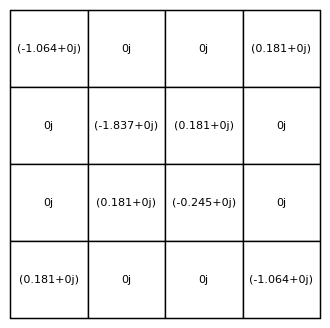

In [43]:
from qiskit.quantum_info import SparsePauliOp
hamiltonian = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

import matplotlib.pyplot as plt
import numpy as np
matr = np.around(hamiltonian.to_matrix(), 3)
#simply to display the matrix matr as diagram, nothing complex 
plt.figure(1, figsize=(4, 4))
tb = plt.table(cellText=matr, loc=(0,0), cellLoc='center')

tc = tb.properties()['children']
for cell in tc: 
    cell.set_height(1.0/4)
    cell.set_width(1.0/4)

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
tb.auto_set_font_size(False)
tb.set_fontsize(8)
plt.show()

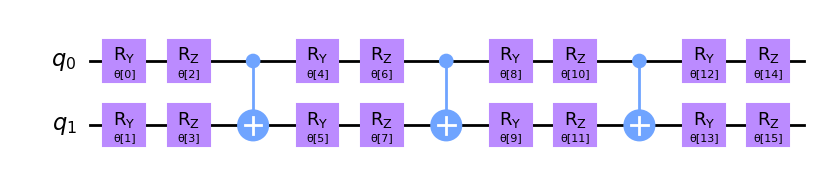

In [44]:
from qiskit.circuit.library import EfficientSU2
#ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw('mpl')

In [45]:
num_params = ansatz.num_parameters
num_params


16

In [46]:
from qiskit_ibm_runtime import Estimator


def cost_func(params, ansatz, hamiltonian, estimator):
    energy = estimator.run(ansatz, hamiltonian,
                           parameter_values=params).result().values[0]
    return energy


In [47]:
New parameters


In [48]:
import numpy as np
x0 = 2 * np.pi * np.random.random(num_params)
#hartree fork can be used to reduce no. of iterations needed


In [ ]:
def callback_builder(ansatz, hamiltonian, estimator, callbackd):
    def callback( nfev, parameters, value, stepsize, accepted):
        #number of function evaluations, the parameters, the function value, the stepsize, whether the step was accepted.
        callbackd["n_iters"] += 1
        # Set the prev_vector to the latest one
        callbackd["pvector"] = parameters
        # Compute the value of the cost function at the current vector
        callbackd["cost_old"].append(
            value
        )
        # Grab the current time
        # Find the total time of the execute (after the 1st iteration)
        job = service.jobs(backend_name="ibmq_quito")
        callbackd['final_time'].append(job.metrics()['usage']['seconds'])
        callbackd['step_size'].append(stepsize)
        # Print to screen on single line
        print(
            "Iters. done: {} [Avg. time per iter: {}]".format(callback_dict["iters"], time_str),
            end="\r",
            flush=True,
        )

    return callback

callbackd = {
    'n_iters':none,
    'pvector':[],
    'cost_old':[],
    'final_time':[],
    'step_size':[],
    'cc':[]#concurrency
}

In [49]:
from qiskit_ibm_runtime import Session
from qiskit.algorithms.optimizers import SPSA
with Session(backend=backend):
    estimator = Estimator(options={"shots": int(1e4)})
    def costfspsa(params):
        return cost_func(params, ansatz, hamiltonian, estimator)
    
    callback = callback_builder(ansatz, hamiltonian, estimator, callbackd)
    spsa = SPSA(callback=callback, maxiter=125)
    spsa.minimize(
        costfspsa,
        x0
    )


C:\Users\saxen\AppData\Local\Temp\ipykernel_7032\2497533903.py:18: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.seconds' attribute instead.
  (datetime.strptime(job.metrics()['timestamps']['finished'], "%Y-%m-%dT%H:%M:%S.%fZ")
C:\Users\saxen\AppData\Local\Temp\ipykernel_7032\2497533903.py:19: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.seconds' attribute instead.
  -datetime.strptime(job.metrics()['timestamps']['running'], "%Y-%m-%dT%H:%M:%S.%fZ")).total_seconds()


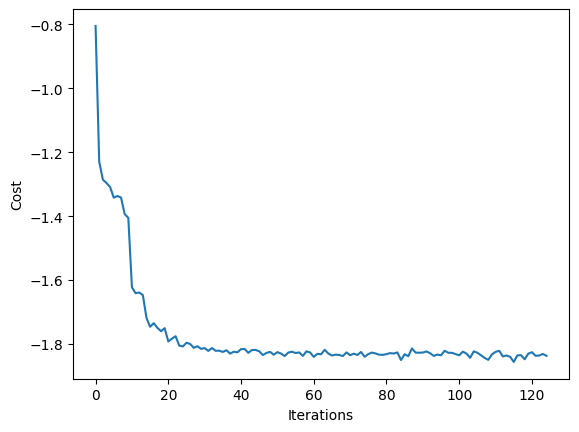

Original EigenValue -1.8572750302023828
[array([3.40870355, 1.71621524, 5.52360729, 3.62975713, 0.67650457,
       2.49895664, 0.75220275, 6.08316081, 0.82581219, 5.74037133,
       5.46754648, 1.27773754, 3.33950164, 2.86365431, 4.06152835,
       3.99506585]), array([2.36683674, 2.75808205, 6.5654741 , 4.67162394, 1.71837138,
       3.54082346, 1.79406956, 7.12502763, 1.86767901, 4.69850451,
       6.50941329, 0.23587073, 2.29763482, 3.90552112, 5.10339517,
       5.03693267]), array([2.82402416, 2.30089463, 6.10828667, 5.12881137, 1.26118396,
       3.99801088, 2.25125699, 7.58221505, 2.32486643, 4.24131709,
       6.05222587, 0.69305815, 1.8404474 , 4.36270854, 5.56058259,
       5.49412009]), array([2.84997682, 2.32684728, 6.13423933, 5.10285871, 1.28713661,
       4.02396354, 2.27720964, 7.60816771, 2.35081909, 4.26726974,
       6.07817852, 0.71901081, 1.86640005, 4.33675589, 5.53462994,
       5.52007275]), array([2.77641822, 2.40040587, 6.20779792, 5.17641731, 1.36069521,
    

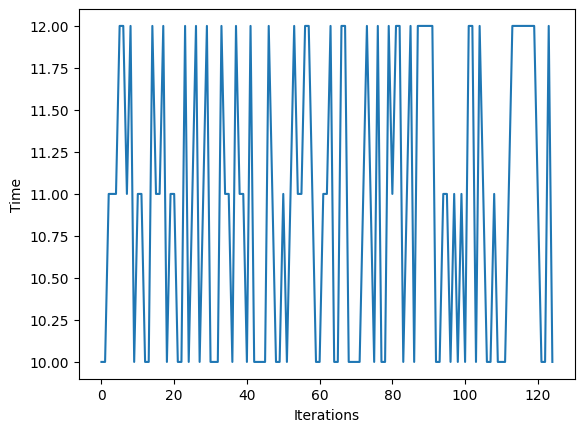

In [59]:
import matplotlib.pyplot as plt
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

fig1, pi = plt.subplots()
pi.plot(range(callbackd["n_iter"]), callbackd["cost_old"])
pi.set_xlabel("Iterations")
pi.set_ylabel("Cost")
plt.show()
print('Original EigenValue', NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian).eigenvalue)
print(callbackd['pvector'])

fig2, pt = plt.subplots()
pt.plot(range(callbackd["n_iter"]), callbackd["final_time"])
pt.set_xlabel("Iterations")
pt.set_ylabel("Time")
plt.show()


In [61]:
from qiskit.quantum_info import Statevector, concurrence
for j in callbackd['pvector']:
    bound_ansatz = ansatz.bind_parameters(j)
    i = Statevector.from_instruction(bound_ansatz)
    callbackd['cc'].append(concurrence(i))

In [66]:
print(callbackd['cc'])

[0.8565280230515102, 0.6282219550734454, 0.6675202696887647, 0.6750123236599541, 0.7131494367760859, 0.7569244170547521, 0.7620017428756032, 0.791205913546098, 0.6290139207844339, 0.6287930827093469, 0.44315610259810456, 0.45191621308249486, 0.4707615153267119, 0.487877506861431, 0.4067656744673935, 0.32741747736758803, 0.30312050686286424, 0.30751236365680124, 0.30423055238338104, 0.18772608730469897, 0.23752938705874707, 0.24004263693693656, 0.26367818430003903, 0.200398334529697, 0.2015649043693515, 0.21426736228087256, 0.21810100294924423, 0.20501601794221067, 0.20559762271495094, 0.15622124247101077, 0.16016280653595064, 0.12294947095205166, 0.12273727997858155, 0.11888837528677762, 0.12482043687691946, 0.11979747085168078, 0.11869941691574705, 0.12013397592668328, 0.11943847089953076, 0.11874860283236262, 0.12100772422702588, 0.1160364618934542, 0.11852470745026462, 0.12455743893575803, 0.13498374521392345, 0.13323363836468705, 0.13688722032506506, 0.13668824902504476, 0.14484792

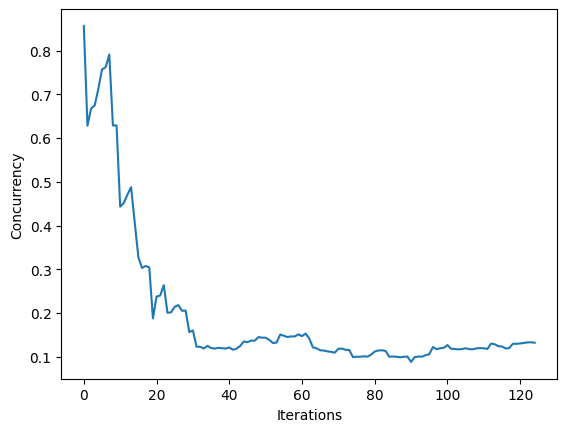

In [67]:
fig3, pc = plt.subplots()
pc.plot(range(callbackd["n_iter"]), callbackd["cc"][0:callbackd["n_iter"]])
pc.set_xlabel("Iterations")
pc.set_ylabel("Concurrency")
plt.show()